# BiLSTM with N-GRAMS MODEL MSCC

In [ ]:
#libraries imported for the model, Tenserflow and Keras are the main libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import numpy as np

In [ ]:
#Holmes_Training_Data is used for the model, the files are opened and read
import os
import math,random
from nltk import word_tokenize as tokenize

TRAINING_DIR="/content/drive/MyDrive/AdvancedNLPWeek2/lab2resources/sentence-completion/Holmes_Training_Data"  #this needs to be the parent directory for the training corpus

def get_training_testing(training_dir=TRAINING_DIR,split=0.8):

    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    random.seed(53)  #if you want the same random split every time
    random.shuffle(filenames)
    index=int(n*split)
    return(filenames[:index],filenames[index:])

trainingfiles,heldoutfiles=get_training_testing()

There are 522 files in the training directory: /content/drive/MyDrive/AdvancedNLPWeek2/lab2resources/sentence-completion/Holmes_Training_Data


In [ ]:
def train_from_corpus(training_dir=TRAINING_DIR,files=[]):
        alltokens=""
        #reading corpus and tokenize
        for afile in files:
            try:
                with open(os.path.join(training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        alltokens+=line
            except UnicodeDecodeError:
                print("UnicodeDecodeError reading {}: ignoring file".format(afile))

        return alltokens 

In [ ]:
import nltk
nltk.download('punkt')
words=train_from_corpus(files=trainingfiles[:1])

len(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


535512

In [ ]:
#all the punctuations are replaced by line space to create smaller sentences that make easier the finding of n-grams. 
words=words.replace(",",".")
words=words.replace(";",".")
words=words.replace("!",".")
words=words.replace("?",".")
words=words.replace(":",".")
words=words.replace("*","")
words=words.replace(".","\n")

words

'The Project Gutenberg Etext of The Holy War\n by John Bunyan#2 in our series by John BunyanCopyright laws are changing all over the world\n be sure to checkthe copyright laws for your country before posting these files\nPlease take a look at the important information in this header\nWe encourage you to keep this file on your own disk\n keeping anelectronic path open for the next readers\n  Do not remove this\nWelcome To The World of Free Plain Vanilla Electronic TextsEtexts Readable By Both Humans and By Computers\n Since 1971These Etexts Prepared By Hundreds of Volunteers and DonationsInformation on contacting Project Gutenberg to get Etexts\n andfurther information is included below\n  We need your donations\nThe Holy Warby John BunyanJanuary\n 1996 [Etext #395]The Project Gutenberg Etext of The Holy War\n by John BunyanThis file should be named hlywr10\ntxt or hlywr10\nzipCorrected EDITIONS of our etexts get a new NUMBER\n hlywr11\ntxt\nVERSIONS based on separate sources get new LE

In [ ]:
#each word is converted to lowercase
corpus=words.lower().split("\n")

In [ ]:
corpus

In [ ]:
#the Keras library tokenizer
tokenizer=Tokenizer()

In [ ]:
#the tokenizer works for the corpus
tokenizer.fit_on_texts(corpus)

In [ ]:
#the unique words are found, +1 is used for an exceptional word out of the vocabulary
total_words = len(tokenizer.word_index) + 1 

In [ ]:
print(tokenizer.word_index)
print(total_words)

{'the': 1, 'and': 2, 'of': 3, 'to': 4, 'that': 5, 'he': 6, 'in': 7, 'they': 8, 'mansoul': 9, 'was': 10, 'for': 11, 'a': 12, 'his': 13, 'them': 14, 'you': 15, 'town': 16, 'it': 17, 'as': 18, 'be': 19, 'but': 20, 'i': 21, 'their': 22, 'this': 23, 'with': 24, 'my': 25, 'so': 26, 'him': 27, 'had': 28, 'by': 29, 'not': 30, 'were': 31, 'all': 32, 'now': 33, 'is': 34, 'have': 35, 'mr': 36, 'at': 37, 'lord': 38, 'did': 39, 'also': 40, 'when': 41, 'what': 42, 'said': 43, 'will': 44, 'or': 45, "'": 46, 'do': 47, 'then': 48, 'upon': 49, 'from': 50, 'diabolus': 51, 'should': 52, 'captain': 53, 'prince': 54, 'if': 55, 'up': 56, 'we': 57, 'would': 58, 'thou': 59, 'men': 60, 'one': 61, 'there': 62, 'made': 63, 'your': 64, 'are': 65, 'shall': 66, 'our': 67, 'against': 68, 'out': 69, 'captains': 70, 'thee': 71, 'thy': 72, 'come': 73, 'us': 74, 'into': 75, 'nor': 76, 'emmanuel': 77, 'yet': 78, 'these': 79, 'more': 80, 'before': 81, 'no': 82, 'good': 83, 'came': 84, 'man': 85, 'could': 86, 'know': 87, 's

In [ ]:
#n_gram sequences are found
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [ ]:
#the longest n_gram is found
max_sequence_len = max([len(x) for x in input_sequences])

In [ ]:
max_sequence_len

35

In [ ]:
#padding is done for converting the n_grams to the vectors with the length of the longest n_gram
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


In [ ]:
#input features and labels are created
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

In [ ]:
len(labels)

78170

In [ ]:
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
len(ys)

78170

In [ ]:
#the model training is started with the convenient inputs
model1 = Sequential()
model1.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model1.add(Bidirectional(LSTM(150)))
model1.add(Dropout(0.2))
model1.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.001)
model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model1.fit(xs, ys, epochs=40, verbose=1,batch_size=256)
print(model1)


Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


306/306 [==============================] - 170s 545ms/step - loss: 6.8257 - accuracy: 0.0577
Epoch 2/40
306/306 [==============================] - 164s 535ms/step - loss: 6.3681 - accuracy: 0.0889
Epoch 3/40
306/306 [==============================] - 164s 535ms/step - loss: 6.0371 - accuracy: 0.1076
Epoch 4/40
306/306 [==============================] - 162s 531ms/step - loss: 5.7690 - accuracy: 0.1238
Epoch 5/40
306/306 [==============================] - 164s 535ms/step - loss: 5.5421 - accuracy: 0.1384
Epoch 6/40
306/306 [==============================] - 163s 534ms/step - loss: 5.3451 - accuracy: 0.1495
Epoch 7/40
306/306 [==============================] - 163s 532ms/step - loss: 5.1699 - accuracy: 0.1594
Epoch 8/40
306/306 [==============================] - 159s 519ms/step - loss: 5.0112 - accuracy: 0.1678
Epoch 9/40
306/306 [==============================] - 160s 523ms/step - loss: 4.8651 - accuracy: 0.1762
Epoch 10/40
306/306 [==============================] - 160s 524ms/step - lo

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

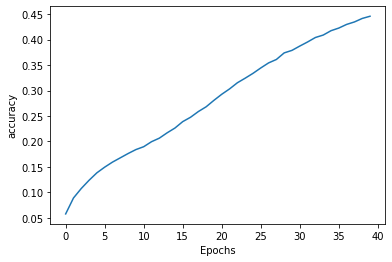

In [ ]:
#accuracy vs Epochs graph of the model
plot_graphs(history, 'accuracy')

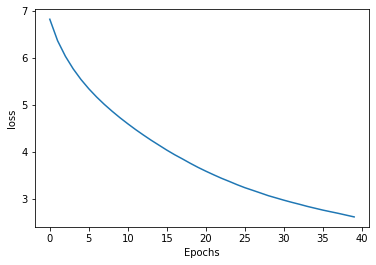

In [ ]:
#loss vs Epochs graph of the model
plot_graphs(history, 'loss')

In [ ]:
#the next word prediction function for the model
def prediction(seed_text, next_words): 
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model1.predict(token_list, verbose=1), axis=-1)
    ouput_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += ''+output_word
  print(seed_text)
  return output_word

1/1 [==============================] - 0s 29ms/step
He held in his hand a garrison


'garrison'

In [ ]:
!python3 -m spacy download en_core_web_sm


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
import pandas as pd
test_data=pd.read_csv(os.path.join('/content/drive/MyDrive/AdvancedNLPWeek2/lab2resources/sentence-completion/testing_data.csv'),index_col=0)
test_answer=pd.read_csv(os.path.join('/content/drive/MyDrive/AdvancedNLPWeek2/lab2resources/sentence-completion/test_answer.csv'),index_col=0).iloc[:,0]

In [ ]:
#the predicted words option is returned
def returncorrect(options,answer):
  options.index.name="abcde"
  df = options.reset_index(name='names')
  for i in range(len(df["names"])):
    if str(df["names"][i])==str(answer[0]):
      return str(df["abcde"][i])



In [ ]:
#all of the test_data's questions are solved and the predictions are put into a list
import operator
def findingopt(test_data,test_answer):
  answersofmodel=[]
  for index, row in test_data.iterrows():
      question=row[0]
      options=row[1:]
      predicted= prediction(question.split("_")[0], 1)
      optionpredictide={}
      for option in options:
        sent1 = nlp(predicted)
        sent2 = nlp(option)
        optionpredictide[sent2]=sent1.similarity(sent2)
      a= sorted(optionpredictide.items(), key=operator.itemgetter(1),reverse=True)
      answer = a[0]
      answermodel=returncorrect(options,answer)
      answersofmodel.append(answermodel)
  return answersofmodel
      

In [ ]:
answerslist=findingopt(test_data,test_answer)

In [ ]:
#the results are compared with the test_answer results and an accuracy ratio is get
def get_accuracy(answerslist,test_answer):
    stranswerslist=[]
    for l in answerslist:
      stranswerslist.append(l.replace(")",""))
    correct=0
    for i in range(len(stranswerslist)):
      if stranswerslist[i] == test_answer[i+1]:
        correct+=1
    return correct/len(stranswerslist)

In [ ]:
get_accuracy(answerslist,test_answer)

0.20865384615384616

In [ ]:
########################################################

# BERT MODEL FOR MSCC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#transformers are imported
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
     |████████████████████████████████| 6.6 MB 44.5 MB/s 
     |████████████████████████████████| 596 kB 57.2 MB/s 
     |████████████████████████████████| 895 kB 54.2 MB/s 
     |████████████████████████████████| 77 kB 8.1 MB/s 


In [ ]:
#libraries
import os,random,math,sys
import multiprocessing
import pandas as pd
import numpy as np
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertTokenizer
from tqdm import tqdm
device='cuda' if torch.cuda.is_available() else 'cpu'

parentdir='data/raw_data'
TRAINING_DIR=parentdir+'/content/drive/MyDrive/AdvancedNLPWeek2/lab2resources/sentence-completion/Holmes_Training_Data'

In [ ]:
test_data=pd.read_csv(os.path.join('/content/drive/MyDrive/AdvancedNLPWeek2/lab2resources/sentence-completion/testing_data.csv'),index_col=0)
test_answer=pd.read_csv(os.path.join('/content/drive/MyDrive/AdvancedNLPWeek2/lab2resources/sentence-completion/test_answer.csv'),index_col=0).iloc[:,0]

In [ ]:
test_data.head()


,question,a),b),c),d),e)
id,,,,,,
1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


In [ ]:
test_answer.head()

id
1    c
2    a
3    d
4    c
5    d
Name: answer, dtype: object

In [ ]:
answers={
    0:'a',
    1:'b',
    2:'c',
    3:'d',
    4:'e'
}
#Converting options' text into id of the tokenizer, indices of each option's text are returned
def get_options_indices(tokenizer,prefix,options):
    indices=[tokenizer(option)['input_ids'][1:-1] for option in options]
    for i,option in enumerate(options):
        if prefix+option in tokenizer.vocab.keys():
            indices[i]=[tokenizer.convert_tokens_to_ids(prefix+option)]
    return indices
#cosine similarity is used for finding the vector similarities
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

In [ ]:
#model
class pretrained_model_tester():
    def __init__(self,test_df,model_name):
        self.tokenizer=AutoTokenizer.from_pretrained(model_name)
        self.model=AutoModelForMaskedLM.from_pretrained(model_name).to(device)
        self.model.eval()
        self.test_data=test_df.copy()
        self.test_data.question=self.test_data.question.str.replace('_____','[MASK]')
        self.prefix=''
    #sentence splitting, tokenizing, applying model and getting result 
    #use only the first token of the option is used
    #question is the masked token, options is the string for MSCC
    def predict(self,question,options):
        # tokenizing
        inputs=self.tokenizer(question,return_tensors='pt')
        # move to gpu if available
        inputs={key: value.to(device) for key, value in inputs.items()}
        # misc
        masked_index=np.where((inputs['input_ids']==self.tokenizer.mask_token_id).cpu())[1][0]
        #print(masked_index,"masked_index")
        options_indices=get_options_indices(self.tokenizer,self.prefix,options)
        #print(options_indices,"option_indices")
        # get result  
        with torch.no_grad():
            outputs=self.model(**inputs)[0]
            options_indices=[option[0] for option in options_indices]
            outputs=outputs[:,masked_index,options_indices]
            return torch.argmax(outputs).item()
    #the prediction function is used for the whole test.The output is a pandas series with the answers of the questions.
    def batch_predict(self):
        result=[]
        for index, row in self.test_data.iterrows():
            question=row[0]
            options=row[1:].tolist()
           # print(options)
            predicted_ind=self.predict(question,options)
           # print(predicted_ind)
            result.append(answers[predicted_ind])
        return pd.Series(result,index=test_data.index)

In [ ]:
#correct prediction accuracy finding function
def get_accuracy(prediction,labels):
    return sum(prediction==labels)/len(labels)

In [ ]:
col_names=['model_name','accuracy']_
result=[]
model_name = 'bert-base-uncased'
pretrained_model=pretrained_model_tester(test_data,model_name)
predictions=pretrained_model.batch_predict()
result.append([model_name,get_accuracy(predictions,test_answer)])
result=pd.DataFrame(result,columns=col_names)
display(result)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,model_name,accuracy
0,bert-base-uncased,0.75
